# MNIST convnet (batch norm, dropout, data augmentation)

## Data acquisition and preparation

In [1]:
import numpy as np
import keras 
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Convolution2D, Lambda
from keras.layers import Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 860M (CNMeM is disabled, cuDNN 5103)
/home/artir/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
(X_train, y_train), (X_test, y_test)=mnist.load_data()
X_train=np.expand_dims(X_train,1)
X_test=np.expand_dims(X_test,1)
print(X_train.shape,X_train.dtype)


(60000, 1, 28, 28) uint8


In [3]:
# Preprocessing: substract the mean of the dataset
mean_train=X_train.mean()
print(mean_train.dtype)
#Bad thing! We want float32 to reduce memory use
mean_train=X_train.mean().astype(np.float32)
std_train=X_train.std().astype(np.float32)
def norm_input(x): return (x-mean_train)/std_train

float64


In [4]:
y_test.shape

(10000,)

In [5]:
#Onehot encode the output
from keras.utils.np_utils import to_categorical
def onehot(array):
    return to_categorical(array)
y_train=onehot(y_train)
y_test=onehot(y_test)

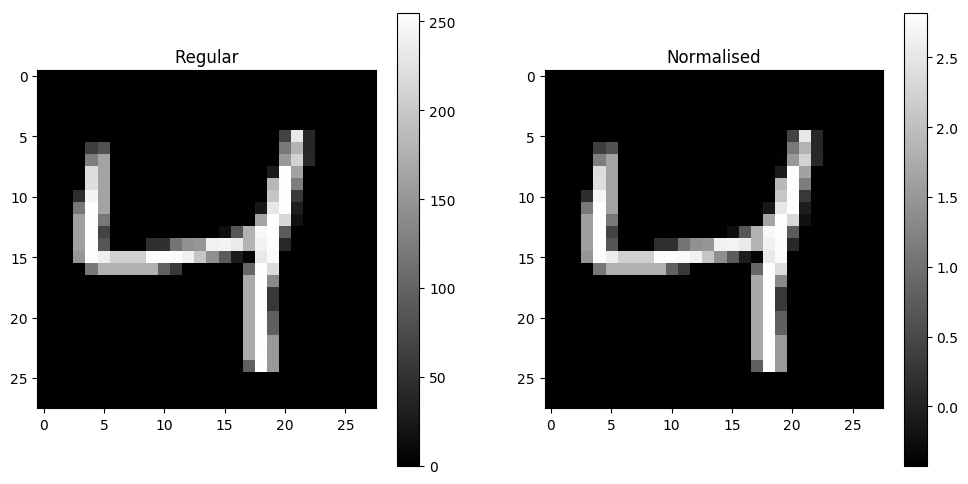

In [6]:
#Let's visualise the input and the normalised input
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
n=2
plt.imshow(X_train[n,:,:,:].squeeze().astype(np.uint8),cmap='gray')
plt.title('Regular')
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Normalised')
plt.imshow(norm_input(X_train[n,:,:,:]).squeeze(),cmap='gray')
#They look the same because of the scaling that matplotlib does. Actual values are different
plt.colorbar()

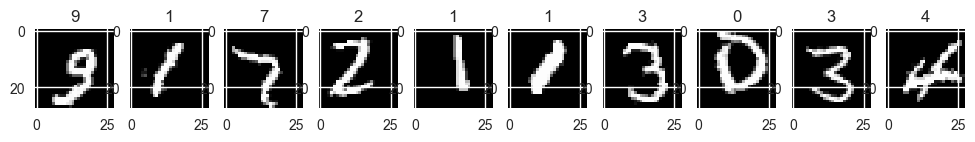

In [19]:
# Create a generator to acquire batches from directories
# Training batches are augmented
train_imgs=image.ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.3,
    zoom_range=0.08
)
batch_size=64
batch_train=train_imgs.flow(X_train,y_train,batch_size=batch_size)

# Testing batches are not augmented
test_imgs=image.ImageDataGenerator()
batch_test=test_imgs.flow(X_test,y_test,batch_size=batch_size,shuffle=False)

def to_number(array):
    return np.asscalar(np.argwhere(array))
def plot_batch(batch,n=4,label=''):
    plt.figure(figsize=(12,6))    
    for i in range(n):
        plt.subplot(1,n,i+1)        
        plt.imshow(batch[0][i,:,:,:].squeeze().astype(np.uint8),cmap='gray')
        plt.title(to_number(batch[1][i]))
plot_batch(next(batch_train),10)

## Convolutional network definition

In [47]:
#Inputs are (1,28,28)
#border_same to avoid ZeroPadding
class miniNet():
    def __init__(self):
        self.lr=0.01
        self.get_model()
    def ConvBlock(self,n):
        model=self.model
        model.add(Convolution2D(n,3,3,activation='relu',border_mode='same'))
        model.add(BatchNormalization(axis=1))
        model.add(Convolution2D(n,3,3,activation='relu',border_mode='same'))
        model.add(MaxPooling2D())                          
    def FlatBlock(self):
        model=self.model
        model.add(BatchNormalization()) 
        model.add(Flatten())
        model.add(BatchNormalization()) 
        model.add(Dense(512,activation='relu'))
        model.add(BatchNormalization(axis=1))
        model.add(Dropout(0.4))
        model.add(Dense(10,activation='softmax'))
    def get_model(self):
        self.model=Sequential()
        self.model.add(Lambda(norm_input,input_shape=(1,28,28),output_shape=(1,28,28)))
        self.ConvBlock(32)
        self.ConvBlock(64)
        self.FlatBlock()
        self.compile()
        return self.model
    def fit(self,train_batch,val_batch,nb_epoch=1):
       
        self.model.fit_generator(train_batch,nb_epoch=nb_epoch,
                                 validation_data=val_batch,
                                 nb_val_samples=val_batch.N,
                                samples_per_epoch=train_batch.N)
    def summary(self):
        self.model.summary()
    def set_lr(self,lr):
        self.lr=lr
        self.model.optimizer.lr=lr
    def compile(self,lr=0.01):
        self.model.compile(Adam(lr=self.lr),loss='categorical_crossentropy',metrics=['accuracy'])
     
CN=miniNet()
CN.summary()
#CN.fit(batch_train,batch_test,1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_30 (Lambda)               (None, 1, 28, 28)     0           lambda_input_30[0][0]            
____________________________________________________________________________________________________
convolution2d_117 (Convolution2D)(None, 32, 28, 28)    320         lambda_30[0][0]                  
____________________________________________________________________________________________________
batchnormalization_146 (BatchNorm(None, 32, 28, 28)    64          convolution2d_117[0][0]          
____________________________________________________________________________________________________
convolution2d_118 (Convolution2D)(None, 32, 28, 28)    9248        batchnormalization_146[0][0]     
___________________________________________________________________________________________

In [20]:
#CN.model.save_weights('weights.pkl')
#CN.model.load_weights('weights.pkl')

In [21]:
# CN.set_lr(0.1)
# CN.fit(batch_train,batch_test,1)
# CN.set_lr(0.001)
# CN.fit(batch_train,batch_test,3)
#CN.model.save_weights('weights_fine.pkl')
CN.model.load_weights('weights_fine.pkl')

## Prediction and confusion matrix

In [22]:
#Predictions
def to_number_a(array):
    if array.ndim>1:
        return np.nonzero(array)[1]
    else:        
        return np.nonzero(array)[0][0]
preds=CN.model.predict_classes(X_test,batch_size=64)
probs=CN.model.predict_proba(X_test,batch_size=64)
ntest_y=to_number_a(y_test)

 7680/10000 [======================>.......] - ETA: 0s

In [23]:
X_train.shape

(60000, 1, 28, 28)

In [24]:
probs[0]

array([  1.54e-09,   2.53e-08,   2.89e-09,   2.90e-11,   1.64e-11,   2.35e-13,   1.92e-14,
         1.00e+00,   8.17e-12,   9.74e-09], dtype=float32)

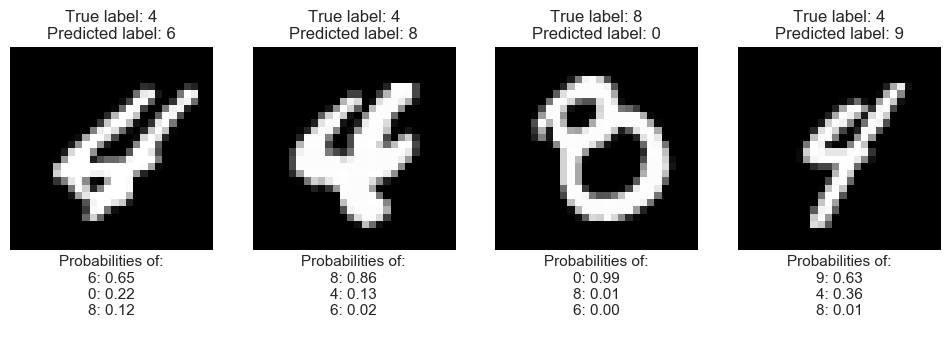

In [25]:
# Some wrong items
n_preds=3
incorrect=np.where(preds!=ntest_y)[0]
from numpy.random import random, permutation
n_items=4
idx=permutation(incorrect)[:n_items]

def plot_idx(idx,n=4):
    plt.figure(figsize=(12,6))    
    for i,img in enumerate(idx):        
        plt.subplot(1,n,i+1)
        plt.imshow(X_test[img,:,:,:].squeeze(),cmap='gray')
        plt.gca().grid(False)
        plt.gca().get_yaxis().set_ticks([])
        plt.gca().get_xaxis().set_ticks([])
        substring='Probabilities of:\n'
        order=np.argsort(probs[img])[::-1][:n_preds]
        top=probs[img][order]
        for j in range(n_preds):            
            substring+='{:d}: {:.2f}\n'.format((order[j]),(top[j]))
        plt.xlabel(substring)
        plt.title('True label: '+str(ntest_y[img])+'\nPredicted label: '+str(preds[img]))
        
        #plt.title(to_number(batch[1][i]))
plot_idx(idx,n_items)


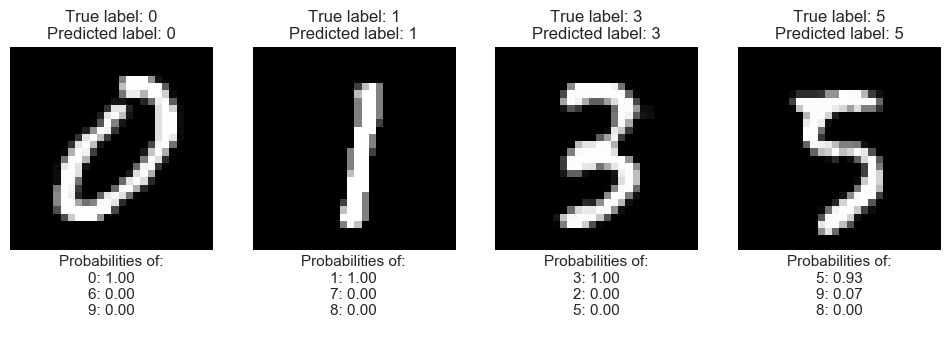

In [26]:
# Some correct items
correct=np.where(preds==ntest_y)[0]
n_items=4
idx=permutation(correct)[:n_items]        
plot_idx(idx,n_items)

[  1.75e-01   4.77e-02   9.49e-02 ...,   1.89e-11   4.63e-15   3.33e-09]


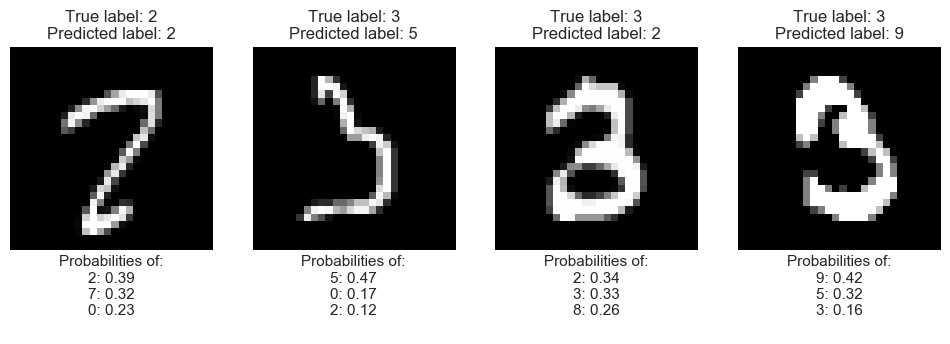

In [27]:
# Items that were highly uncertain
n_items=4
#This gives us the rows that have uncertain labels
most_uncertain=np.argsort(probs.std(axis=1))
np.set_printoptions(precision=2, linewidth=100)
print(probs[most_uncertain,0])
idx=permutation(most_uncertain[:n_items] )       
plot_idx(idx,n_items)

[7 2 1 ..., 4 5 6]


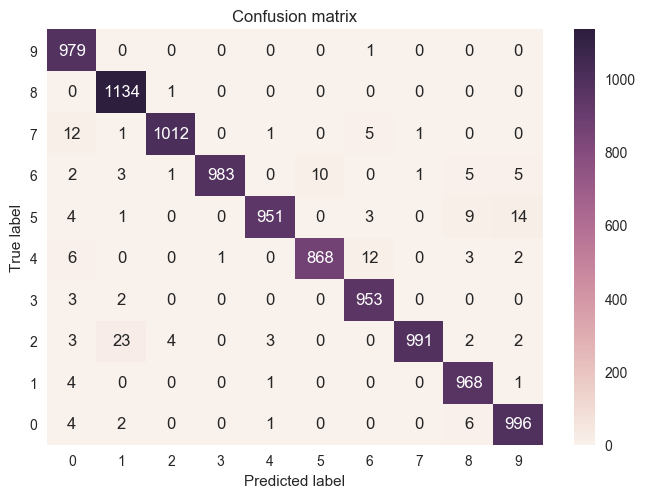

In [28]:
#Confusion matrix

print(to_number_a(y_test))
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ntest_y,preds)
import seaborn as sns
p=sns.heatmap(cm,annot=True,fmt='d')
p.set_yticklabels(range(10),rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

## Ensembling and prediction

In [97]:
class Ensemble():
    def __init__(self,n=2):
        self.n=n
        self.create(n)
    def create(self,n=n):
        self.models=[miniNet() for i in range(n) ]
    def fit(self,train_batch,val_batch,nb_epoch=1):
        for model in self.models:            
            model.fit(train_batch,val_batch,nb_epoch=nb_epoch)
    def predict_proba(self,X_test,batch_size=64):  
            self.probas=np.stack([model.model.predict_proba(X_test,batch_size=batch_size)
                                  for model in self.models])
            return self.probas.mean(axis=0)
        
    def save_weights(self):
        for i,model in enumerate(self.models):
            model.model.save_weights('mnist_ensemble_submodel'+str(i))
    def load_weights(self):
        for i,model in enumerate(self.models):
            model.model.load_weights('mnist_ensemble_submodel'+str(i))
    def evaluate(self,X_test,y_test,batch_size=64):
        for model in self.models:
            loss,acc=model.model.evaluate(X_test,y_test,batch_size=batch_size)
            print('\nLoss:{:.3f} Accuracy:{:.3f}'.format(loss,acc))
    def long_fit(self,train_batch,val_batch,epoch_1=1,epoch_2=3):
        for model in self.models:
            model.set_lr(0.01)
            model.fit(train_batch,val_batch,epoch_1)
            model.set_lr(0.0001)
            model.fit(train_batch,val_batch,epoch_2)
        
ens=Ensemble()
#ens.load_weights()
#A learning rate of 0.001 seems too high, it explodes after a few iterations.
ens.long_fit(batch_train,batch_test,1,1)
ens.save_weights()
    
        

Epoch 1/1
60000/60000 [==============================] - 75s - loss: 0.2538 - acc: 0.9292 - val_loss: 0.0672 - val_acc: 0.9808

In [98]:
#Performance of individual models
ens.evaluate(X_test,y_test)

 9216/10000 [==========================>...] - ETA: 0s
Loss:0.046 Accuracy:0.986
 9664/10000 [===========================>..] - ETA: 0s
Loss:0.064 Accuracy:0.980


In [100]:
keras.metrics.categorical_accuracy(y_test, ens.predict_proba(X_test)).eval()

 7744/10000 [======================>.......] - ETA: 0s

array(0.9904000163078308, dtype=float32)

In [ ]:
import nn_utils

Individual models are up to 0.986 accurate. The ensemble mode goes up to 0.99. This is just with two models and not much training. 